In [2]:
import zipfile
import pandas as pd
import os
from google.colab import drive

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Define path to ZIP file in your Google Drive
zip_path = '/content/drive/My Drive/sudoku.csv.zip'
extract_path = '/content/sudoku_data'  # where we'll extract the zip

# Step 3: Unzip the file
os.makedirs(extract_path, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Step 4: Find and read the extracted CSV
csv_file_path = os.path.join(extract_path, 'sudoku.csv')
sudoku_games = pd.read_csv(csv_file_path)

# Step 5: Display dataset info
print(f"\n✅ Dataset Info:")
print(f"Shape: {sudoku_games.shape}")
print(f"Columns: {sudoku_games.columns.tolist()}")
print(f"Memory usage: {sudoku_games.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Step 6: Show first few rows
print(f"\n🧩 First 5 rows:")
sudoku_games.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

✅ Dataset Info:
Shape: (9000000, 2)
Columns: ['puzzle', 'solution']
Memory usage: 2368.93 MB

🧩 First 5 rows:


,puzzle,solution
0,0700000430400096108006349000940520003584600200...,6795182435437296188216349577943521863584617292...
1,3010865040465210705000000014008000020803479000...,3719865248465213795924738614638197522853479167...
2,0483015603600080909106700030200009355090102006...,7483915623652487919126754834217869355894132766...
3,0083170000042051090000400703271609049014500000...,2983176457642851391539462783271689549814537266...
4,0408906300001368208007405190004670524500207002...,1428956379751368248367425193984671524513287962...


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf

def digit_to_onehot(digit):
    """Convert digit (0-9) to one-hot vector of length 9"""
    if digit == 0:  # empty cell
        return np.zeros(9)
    else:  # digits 1-9 become classes 0-8
        onehot = np.zeros(9)
        onehot[digit - 1] = 1
        return onehot

def sudoku_to_onehot(sudoku_grid):
    """Convert 9x9 sudoku grid to 9x9x9 one-hot representation"""
    onehot_grid = np.zeros((9, 9, 9))
    for i in range(9):
        for j in range(9):
            onehot_grid[i, j, :] = digit_to_onehot(sudoku_grid[i, j])
    return onehot_grid

def create_difference_target(puzzle_onehot, solution_onehot):
    """Create difference target: solution - puzzle (only for empty cells)"""
    difference = np.zeros((9, 9, 9))

    for i in range(9):
        for j in range(9):
            # If puzzle cell is empty (all zeros), put the solution there
            if np.sum(puzzle_onehot[i, j, :]) == 0:  # empty cell
                difference[i, j, :] = solution_onehot[i, j, :]
            # If puzzle cell is filled, difference is zero (already handled by initialization)

    return difference

# Your existing data processing (optimized version)
print("🔄 Processing Sudoku dataset with one-hot encoding...")

# Let's start with a smaller subset for faster processing and testing
SAMPLE_SIZE = 100000  # Start with 500k samples

all_puzzles_onehot = []
all_differences = []

print(f"Processing {SAMPLE_SIZE:,} samples...")

for i in range(SAMPLE_SIZE):
    if i % 10000 == 0:
        print(f"  Processed {i:,} samples...")

    # Convert string to numpy array and reshape to 9x9
    puzzle = np.array([int(d) for d in sudoku_games.iloc[i, 0]]).reshape(9, 9)
    solution = np.array([int(d) for d in sudoku_games.iloc[i, 1]]).reshape(9, 9)

    # Convert to one-hot representation
    puzzle_onehot = sudoku_to_onehot(puzzle)
    solution_onehot = sudoku_to_onehot(solution)

    # Create difference target (solution - puzzle, only for empty cells)
    difference = create_difference_target(puzzle_onehot, solution_onehot)

    all_puzzles_onehot.append(puzzle_onehot)
    all_differences.append(difference)

print("✅ Data processing complete!")

# Convert to numpy arrays
X = np.array(all_puzzles_onehot)  # shape (num_samples, 9, 9, 9)
y = np.array(all_differences)     # shape (num_samples, 9, 9, 9)

print(f"📊 Dataset shapes:")
print(f"  Puzzles (X): {X.shape}")
print(f"  Differences (y): {y.shape}")

# Check sample data
print(f"\n🔍 Sample puzzle (first cell one-hot):")
print(f"Original digit: {sudoku_games.iloc[0, 0][0]}")
print(f"One-hot: {X[0][0, 0, :]}")

print(f"\n🎯 Sample difference (check an empty cell):")
# Find first empty cell in original puzzle
original_puzzle = np.array([int(d) for d in sudoku_games.iloc[0, 0]]).reshape(9, 9)
empty_positions = np.where(original_puzzle == 0)
if len(empty_positions[0]) > 0:
    empty_i, empty_j = empty_positions[0][0], empty_positions[1][0]
    print(f"Empty cell at ({empty_i}, {empty_j}):")
    print(f"Difference target: {y[0][empty_i, empty_j, :]}")

# Prepare data for the model
print(f"\n🛠️  Preparing data for training...")

# Data is already in the right format for CNN: (samples, 9, 9, 9)
X_model = X.astype(np.float32)
y_model = y.astype(np.float32)

print(f"📈 Model-ready data shapes:")
print(f"  X_model: {X_model.shape}")
print(f"  y_model: {y_model.shape}")
print(f"  X_model dtype: {X_model.dtype}")
print(f"  y_model dtype: {y_model.dtype}")

# Split data
print(f"\n✂️  Splitting data...")
X_train, X_val, y_train, y_val = train_test_split(
    X_model, y_model,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print(f"🎯 Training data:")
print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  X_val: {X_val.shape}")
print(f"  y_val: {y_val.shape}")

# Memory usage check
total_memory = (X_train.nbytes + y_train.nbytes + X_val.nbytes + y_val.nbytes) / 1024**2
print(f"\n💾 Total memory usage: {total_memory:.2f} MB")

print(f"\n🚀 Data is ready for training!")
print(f"   Input: Puzzles as (9,9,9) one-hot - filled cells have class vectors, empty cells are zeros")
print(f"   Output: Differences as (9,9,9) one-hot - only empty cell positions have non-zero vectors")
print(f"   To get final solution: Add input + predicted_output")

# Verification function
def verify_data_integrity(sample_idx=0):
    """Verify that our data processing is correct"""
    print(f"\n🔬 Verification for sample {sample_idx}:")

    # Original data
    original_puzzle = np.array([int(d) for d in sudoku_games.iloc[sample_idx, 0]]).reshape(9, 9)
    original_solution = np.array([int(d) for d in sudoku_games.iloc[sample_idx, 1]]).reshape(9, 9)

    # Our processed data
    puzzle_onehot = X[sample_idx]
    difference_onehot = y[sample_idx]

    # Reconstruct solution by adding puzzle + difference
    reconstructed_solution_onehot = puzzle_onehot + difference_onehot

    # Convert back to digits for verification
    reconstructed_solution = np.zeros((9, 9))
    for i in range(9):
        for j in range(9):
            # Find which class has value 1
            class_idx = np.argmax(reconstructed_solution_onehot[i, j, :])
            reconstructed_solution[i, j] = class_idx + 1  # Convert back to digit 1-9

    print(f"Original solution matches reconstructed: {np.array_equal(original_solution, reconstructed_solution)}")
    if not np.array_equal(original_solution, reconstructed_solution):
        print("❌ Data integrity check failed!")
    else:
        print("✅ Data integrity check passed!")

# Run verification
verify_data_integrity()

🔄 Processing Sudoku dataset with one-hot encoding...
Processing 100,000 samples...
  Processed 0 samples...
  Processed 10,000 samples...
  Processed 20,000 samples...
  Processed 30,000 samples...
  Processed 40,000 samples...
  Processed 50,000 samples...
  Processed 60,000 samples...
  Processed 70,000 samples...
  Processed 80,000 samples...
  Processed 90,000 samples...
✅ Data processing complete!
📊 Dataset shapes:
  Puzzles (X): (100000, 9, 9, 9)
  Differences (y): (100000, 9, 9, 9)

🔍 Sample puzzle (first cell one-hot):
Original digit: 0
One-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0.]

🎯 Sample difference (check an empty cell):
Empty cell at (0, 0):
Difference target: [0. 0. 0. 0. 0. 1. 0. 0. 0.]

🛠️  Preparing data for training...
📈 Model-ready data shapes:
  X_model: (100000, 9, 9, 9)
  y_model: (100000, 9, 9, 9)
  X_model dtype: float32
  y_model dtype: float32

✂️  Splitting data...
🎯 Training data:
  X_train: (80000, 9, 9, 9)
  y_train: (80000, 9, 9, 9)
  X_val: (20000, 9, 9, 9)
  y_

In [6]:
# Updated Sudoku Model for One-Hot Difference Prediction
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Concatenate, Layer, Reshape, Activation
from tensorflow.keras.optimizers import Adam

# Custom layer for resizing (same as before)
class ResizeLayer(Layer):
    def __init__(self, target_size, **kwargs):
        super(ResizeLayer, self).__init__(**kwargs)
        self.target_size = target_size

    def call(self, inputs):
        return tf.image.resize(inputs, self.target_size)

    def get_config(self):
        config = super(ResizeLayer, self).get_config()
        config.update({'target_size': self.target_size})
        return config

def create_sudoku_difference_model():
    """
    Create a Sudoku model that predicts differences (solution - puzzle)
    Input: (9, 9, 9) - puzzle as one-hot
    Output: (9, 9, 9) - difference as one-hot (only for empty cells)
    """
    # ✅ Updated input shape for one-hot encoding
    input_layer = Input(shape=(9, 9, 9))

    # First layer convolutions - adjusted for 9 input channels
    conv_3x3 = Conv2D(18, (3, 3), padding='same', activation='relu')(input_layer)
    conv_9x1 = Conv2D(18, (9, 1), padding='valid', activation='relu')(input_layer)
    conv_9x1 = ResizeLayer((9, 9))(conv_9x1)
    conv_1x9 = Conv2D(18, (1, 9), padding='valid', activation='relu')(input_layer)
    conv_1x9 = ResizeLayer((9, 9))(conv_1x9)
    conv_9x9 = Conv2D(9, (9, 9), padding='valid', activation='relu')(input_layer)
    conv_9x9 = ResizeLayer((9, 9))(conv_9x9)

    concat1 = Concatenate()([conv_3x3, conv_9x1, conv_1x9, conv_9x9])

    # Second layer
    conv_global2 = Conv2D(36, (9, 9), padding='valid', activation='relu')(concat1)
    conv_global2_resized = ResizeLayer((9, 9))(conv_global2)
    conv_local2 = Conv2D(18, (3, 3), padding='same', activation='relu')(concat1)
    conv_1x1_2 = Conv2D(9, (1, 1), padding='same', activation='relu')(concat1)
    concat2 = Concatenate(axis=-1)([conv_local2, conv_global2_resized, conv_1x1_2])

    # Third layer
    conv_global3 = Conv2D(36, (9, 9), padding='valid', activation='relu')(concat2)
    conv_global3_resized = ResizeLayer((9, 9))(conv_global3)
    conv_local3 = Conv2D(18, (3, 3), padding='same', activation='relu')(concat2)
    conv_1x1_3 = Conv2D(9, (1, 1), padding='same', activation='relu')(concat2)
    concat3 = Concatenate(axis=-1)([conv_local3, conv_global3_resized, conv_1x1_3])

    # Fourth layer
    conv_global4 = Conv2D(36, (9, 9), padding='valid', activation='relu')(concat3)
    conv_global4_resized = ResizeLayer((9, 9))(conv_global4)
    conv_local4 = Conv2D(18, (3, 3), padding='same', activation='relu')(concat3)
    conv_1x1_4 = Conv2D(9, (1, 1), padding='same', activation='relu')(concat3)
    concat4 = Concatenate(axis=-1)([conv_local4, conv_global4_resized, conv_1x1_4])

    # Fifth layer
    conv_global5 = Conv2D(36, (9, 9), padding='valid', activation='relu')(concat4)
    conv_global5_resized = ResizeLayer((9, 9))(conv_global5)
    conv_local5 = Conv2D(18, (3, 3), padding='same', activation='relu')(concat4)
    conv_1x1_5 = Conv2D(9, (1, 1), padding='same', activation='relu')(concat4)
    concat5 = Concatenate(axis=-1)([conv_local5, conv_global5_resized, conv_1x1_5])

    # Dense layers for global understanding
    flat = Flatten()(concat3)
    dense1 = Dense(1024, activation='relu')(flat)
    dense2 = Dense(512, activation='relu')(dense1)
    dense3 = Dense(256, activation='relu')(dense2)

    # ✅ Output layer: Predict (9, 9, 9) difference
    # Each cell can be one of 9 classes, so 81 * 9 = 729 outputs
    output_logits = Dense(9 * 9 * 9, activation='linear')(dense2)

    # Reshape to (9, 9, 9)
    output_reshaped = Reshape((9, 9, 9))(output_logits)

    # Apply softmax to each of the 81 cells independently
    # This ensures each cell's 9 class probabilities sum to 1
    output_reshaped_flat = Reshape((81, 9))(output_reshaped)
    output_softmax_flat = Activation('softmax')(output_reshaped_flat)
    output = Reshape((9, 9, 9))(output_softmax_flat)

    return Model(inputs=input_layer, outputs=output)

# Create the updated model
print("🏗️  Creating updated Sudoku difference model...")
sudoku_model = create_sudoku_difference_model()

# ✅ Updated compilation for regression-like problem
# We'll use categorical crossentropy since we're predicting class probabilities
sudoku_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',  # Better for one-hot targets
    metrics=['accuracy']
)

print("✅ Model created and compiled!")
sudoku_model.summary()

# ✅ No normalization needed - our data is already one-hot (0s and 1s)
print("\n📊 Data is ready (no normalization needed for one-hot):")
print(f"  X_train shape: {X_train.shape}")
print(f"  X_train range: [{X_train.min():.1f}, {X_train.max():.1f}]")
print(f"  y_train shape: {y_train.shape}")
print(f"  y_train range: [{y_train.min():.1f}, {y_train.max():.1f}]")

print(f"\n🚀 Ready to train with proper one-hot data!")
print(f"  Input: Puzzles as (9,9,9) one-hot")
print(f"  Output: Differences as (9,9,9) one-hot")
print(f"  Loss: Categorical crossentropy")

# Quick sanity check
print(f"\n🔍 Sanity check:")
print(f"  Expected input shape: {sudoku_model.input_shape}")
print(f"  Expected output shape: {sudoku_model.output_shape}")
print(f"  Actual X_train shape: {X_train.shape}")
print(f"  Actual y_train shape: {y_train.shape}")

# Check if shapes match
input_match = sudoku_model.input_shape[1:] == X_train.shape[1:]
output_match = sudoku_model.output_shape[1:] == y_train.shape[1:]

print(f"  Input shapes match: {input_match}")
print(f"  Output shapes match: {output_match}")

if input_match and output_match:
    print("✅ All shapes are compatible!")
else:
    print("❌ Shape mismatch detected!")

🏗️  Creating updated Sudoku difference model...
✅ Model created and compiled!


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 9, 9, 9)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 1, 9, 18)  │      1,476 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 9, 1, 18)  │      1,476 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 1, 1, 9)   │      6,570 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 9, 9, 18)  │      1,476 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resize_layer_7      │ (None, 9, 9, 18)  │          0 │ conv2d_17[0][0]   │
│ (ResizeLayer)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resize_layer_8      │ (None, 9, 9, 18)  │          0 │ conv2d_18[0][0]   │
│ (ResizeLayer)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resize_layer_9      │ (None, 9, 9, 9)   │          0 │ conv2d_19[0][0]   │
│ (ResizeLayer)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 9, 9, 63)  │          0 │ conv2d_16[0][0],  │
│ (Concatenate)       │                   │            │ resize_layer_7[0… │
│                     │                   │            │ resize_layer_8[0… │
│                     │                   │            │ resize_layer_9[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 1, 1, 36)  │    183,744 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 9, 9, 18)  │     10,224 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resize_layer_10     │ (None, 9, 9, 36)  │          0 │ conv2d_20[0][0]   │
│ (ResizeLayer)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 9, 9, 9)   │        576 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 9, 9, 63)  │          0 │ conv2d_21[0][0],  │
│ (Concatenate)       │                   │            │ resize_layer_10[… │
│                     │                   │            │ conv2d_22[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 1, 1, 36)  │    183,744 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 9, 9, 18)  │     10,224 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resize_layer_11     │ (None, 9, 9, 36)  │          0 │ conv2d_23[0][0]   │
│ (ResizeLayer)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 9, 9, 9)   │        576 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 9, 9, 63)  │          0 │ conv2d_24[0][0],  │
│ (Concatenate)       │                   │            │ resize_layer_11[

 Total params: 6,525,359 (24.89 MB)

 Trainable params: 6,525,359 (24.89 MB)

 Non-trainable params: 0 (0.00 B)


📊 Data is ready (no normalization needed for one-hot):
  X_train shape: (80000, 9, 9, 9)
  X_train range: [0.0, 1.0]
  y_train shape: (80000, 9, 9, 9)
  y_train range: [0.0, 1.0]

🚀 Ready to train with proper one-hot data!
  Input: Puzzles as (9,9,9) one-hot
  Output: Differences as (9,9,9) one-hot
  Loss: Categorical crossentropy

🔍 Sanity check:
  Expected input shape: (None, 9, 9, 9)
  Expected output shape: (None, 9, 9, 9)
  Actual X_train shape: (80000, 9, 9, 9)
  Actual y_train shape: (80000, 9, 9, 9)
  Input shapes match: True
  Output shapes match: True
✅ All shapes are compatible!


🚂 Starting model training...
Epoch 1/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.1169 - loss: 1.1372 - val_accuracy: 0.1538 - val_loss: 1.0910 - learning_rate: 0.0010
Epoch 2/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 35s 6ms/step - accuracy: 0.1671 - loss: 1.0598 - val_accuracy: 0.1956 - val_loss: 1.0044 - learning_rate: 0.0010
Epoch 3/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.1949 - loss: 0.9897 - val_accuracy: 0.2037 - val_loss: 0.9705 - learning_rate: 0.0010
Epoch 4/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.2067 - loss: 0.9546 - val_accuracy: 0.2132 - val_loss: 0.9281 - learning_rate: 0.0010
Epoch 5/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.2217 - loss: 0.9151 - val_accuracy: 0.2261 - val_loss: 0.9016 - learning_rate: 0.0010
Epoch 6/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.2308 - loss: 0.8884 - val_accuracy: 0.2321 - val_loss: 0.8791 - learning_rate: 0.0010
Epoch 7/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━

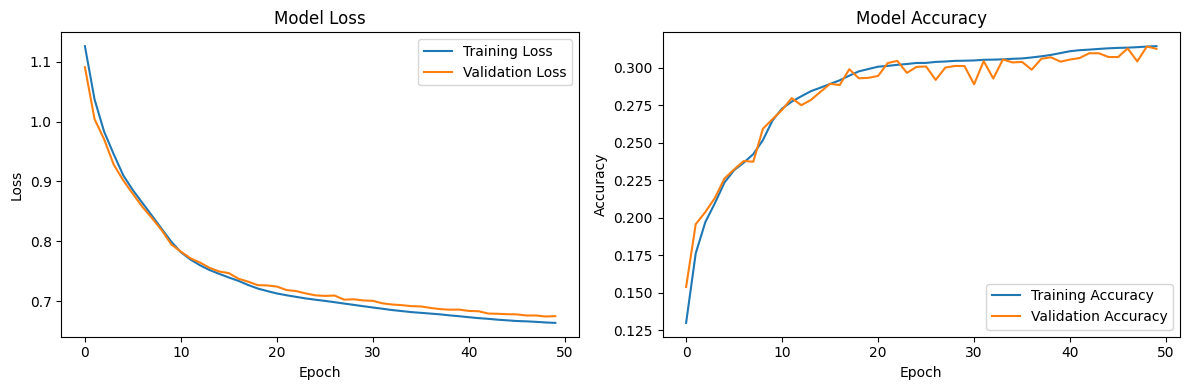


📊 Final Training Results:
  Training Loss: 0.6635
  Validation Loss: 0.6748
  Training Accuracy: 0.3143
  Validation Accuracy: 0.3125

🎯 Model ready for testing!
   Model predicts differences (solution - puzzle)
   To get final solution: puzzle_input + predicted_difference


In [7]:
# BLOCK 5: Train the Updated Sudoku Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

print("🚂 Starting model training...")

# Set up callbacks for better training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Train the model with our one-hot data
history = sudoku_model.fit(
    X_train, y_train,  # No normalization needed for one-hot data
    validation_data=(X_val, y_val),
    epochs=50,  # Start with 50 epochs
    batch_size=32,  # Smaller batch size for complex one-hot data
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("✅ Training completed!")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Print final metrics
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"\n📊 Final Training Results:")
print(f"  Training Loss: {final_train_loss:.4f}")
print(f"  Validation Loss: {final_val_loss:.4f}")
print(f"  Training Accuracy: {final_train_acc:.4f}")
print(f"  Validation Accuracy: {final_val_acc:.4f}")

print(f"\n🎯 Model ready for testing!")
print(f"   Model predicts differences (solution - puzzle)")
print(f"   To get final solution: puzzle_input + predicted_difference")